In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import kurtosis, skew
from scipy.stats import gaussian_kde
from math import sqrt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict

In [21]:
data = pd.read_csv('assets/Exercice 02- energy_consumption_dataset.csv')

data

,Date,Energy Consumption
0,2020-01-01,305.311409
1,2020-01-02,299.374329
2,2020-01-03,307.646359
3,2020-01-04,316.811967
4,2020-01-05,299.651923
...,...,...
1455,2023-12-26,380.398916
1456,2023-12-27,405.951747
1457,2023-12-28,402.642110
1458,2023-12-29,412.140555


In [22]:
data["Energy Consumption"].describe()

count    1460.000000
mean      350.451726
std        31.566215
min       265.886301
25%       324.913290
50%       349.962555
75%       375.550666
max       424.172656
Name: Energy Consumption, dtype: float64

In [149]:
rms_val = sqrt(np.mean(np.square(data["Energy Consumption"])))
skewness_val = skew(data["Energy Consumption"])
kurtosis_val = kurtosis(data["Energy Consumption"])
crest_factor = data["Energy Consumption"].max() / rms_val
form_factor = rms_val / abs(data["Energy Consumption"].mean())

print(f"RMS: {rms_val}")
print(f"Skewness: {skewness_val}")
print(f"Kurtosis: {kurtosis_val}")
print(f"Crest Factor: {crest_factor}")
print(f"Form Factor: {form_factor}")

RMS: 0.5702388903482428
Skewness: 0.0193099005780979
Kurtosis: -0.9201210085675142
Crest Factor: 1.7536509994772602
Form Factor: 1.067351530100872


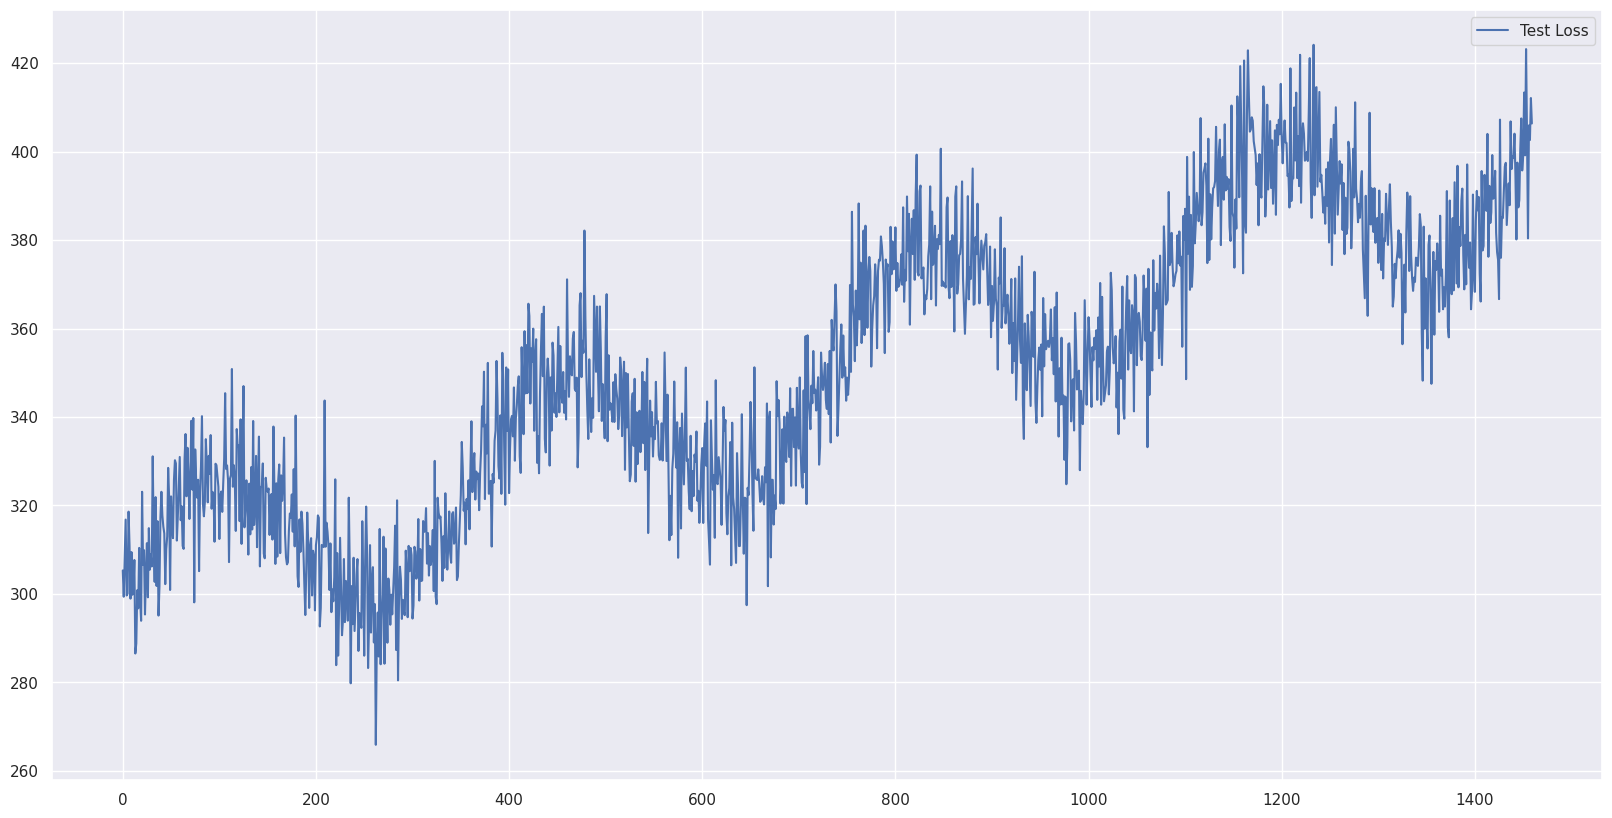

In [24]:
fig = plt.figure(figsize=(20, 10))

plt.plot(data["Energy Consumption"], label="Test Loss")
plt.legend()
plt.show()

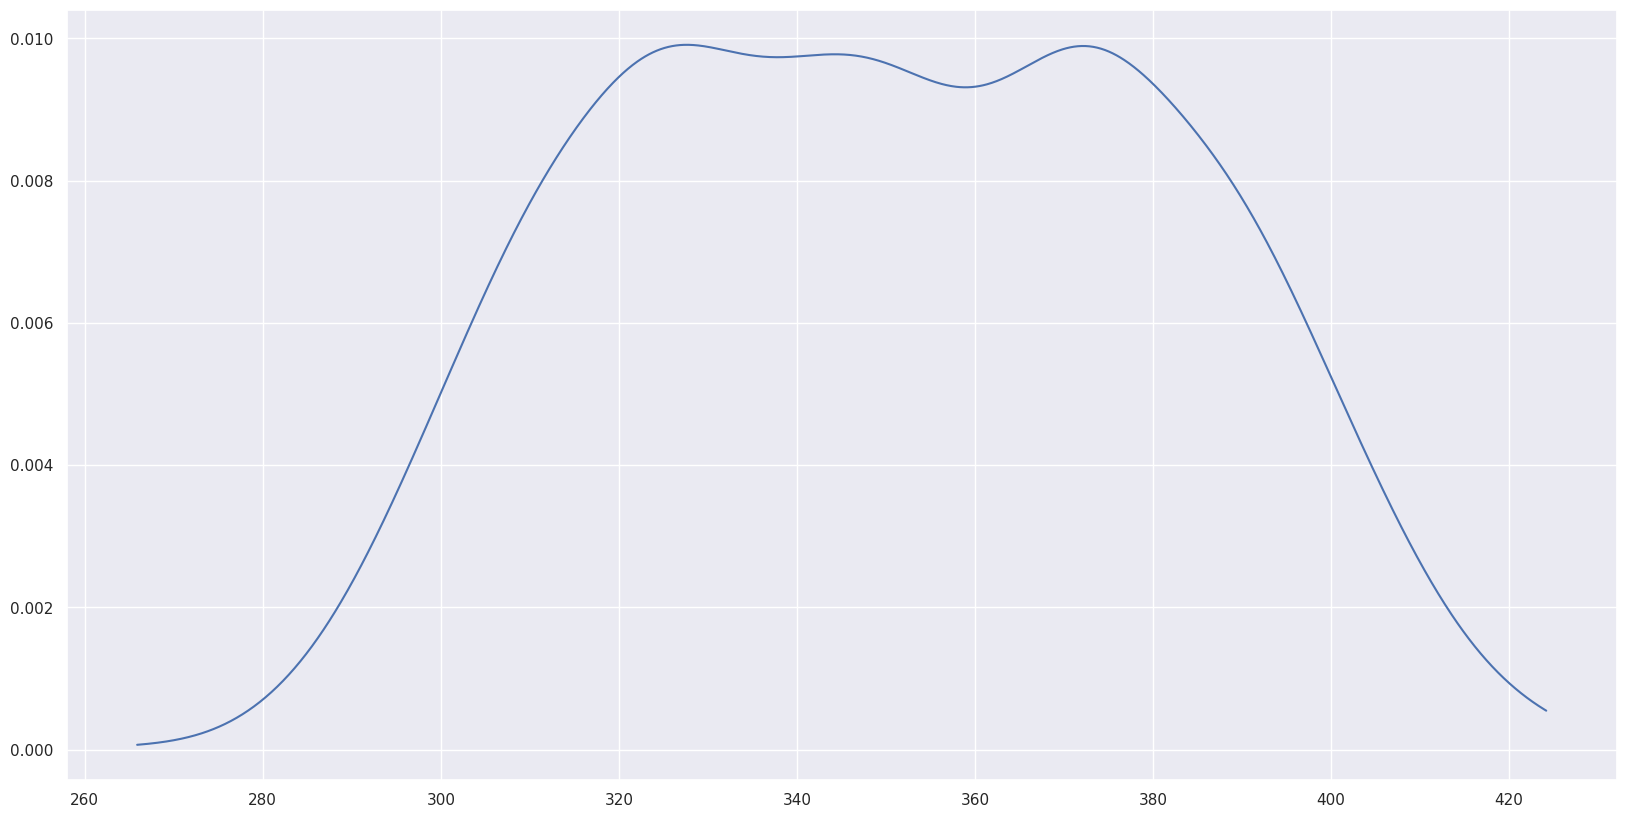

In [25]:
fig = plt.figure(figsize=(20, 10))
density = gaussian_kde(data["Energy Consumption"])
xs = np.linspace(data["Energy Consumption"].min(), data["Energy Consumption"].max(), data["Energy Consumption"].__len__())
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs, density(xs))
plt.show()

<Axes: ylabel='Energy Consumption'>

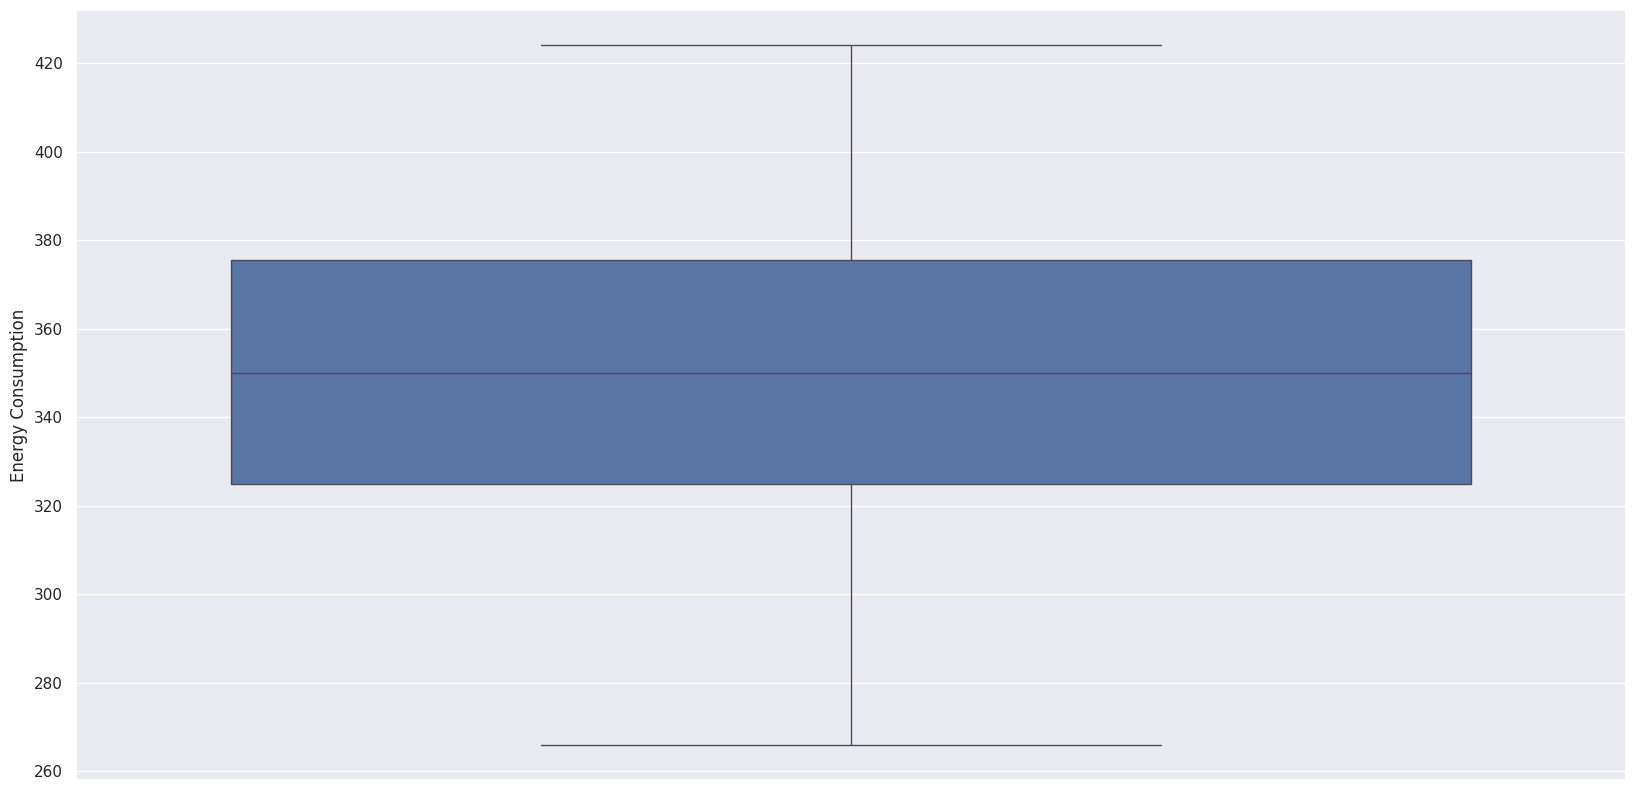

In [26]:
sns.boxplot(data["Energy Consumption"])

In [27]:
Q1 = data["Energy Consumption"].quantile(0.25)
Q3 = data["Energy Consumption"].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

data = data[(data["Energy Consumption"] > lower) & (data["Energy Consumption"] < upper)]

data

,Date,Energy Consumption
0,2020-01-01,305.311409
1,2020-01-02,299.374329
2,2020-01-03,307.646359
3,2020-01-04,316.811967
4,2020-01-05,299.651923
...,...,...
1455,2023-12-26,380.398916
1456,2023-12-27,405.951747
1457,2023-12-28,402.642110
1458,2023-12-29,412.140555


In [28]:
data['Year'] = pd.to_datetime(data['Date'], format='%Y-%m-%d').dt.year
data['Month'] = pd.to_datetime(data['Date'], format='%Y-%m-%d').dt.month
data['Day'] = pd.to_datetime(data['Date'], format='%Y-%m-%d').dt.day

data

,Date,Energy Consumption,Year,Month,Day
0,2020-01-01,305.311409,2020,1,1
1,2020-01-02,299.374329,2020,1,2
2,2020-01-03,307.646359,2020,1,3
3,2020-01-04,316.811967,2020,1,4
4,2020-01-05,299.651923,2020,1,5
...,...,...,...,...,...
1455,2023-12-26,380.398916,2023,12,26
1456,2023-12-27,405.951747,2023,12,27
1457,2023-12-28,402.642110,2023,12,28
1458,2023-12-29,412.140555,2023,12,29


<Axes: xlabel='Month', ylabel='Energy Consumption'>

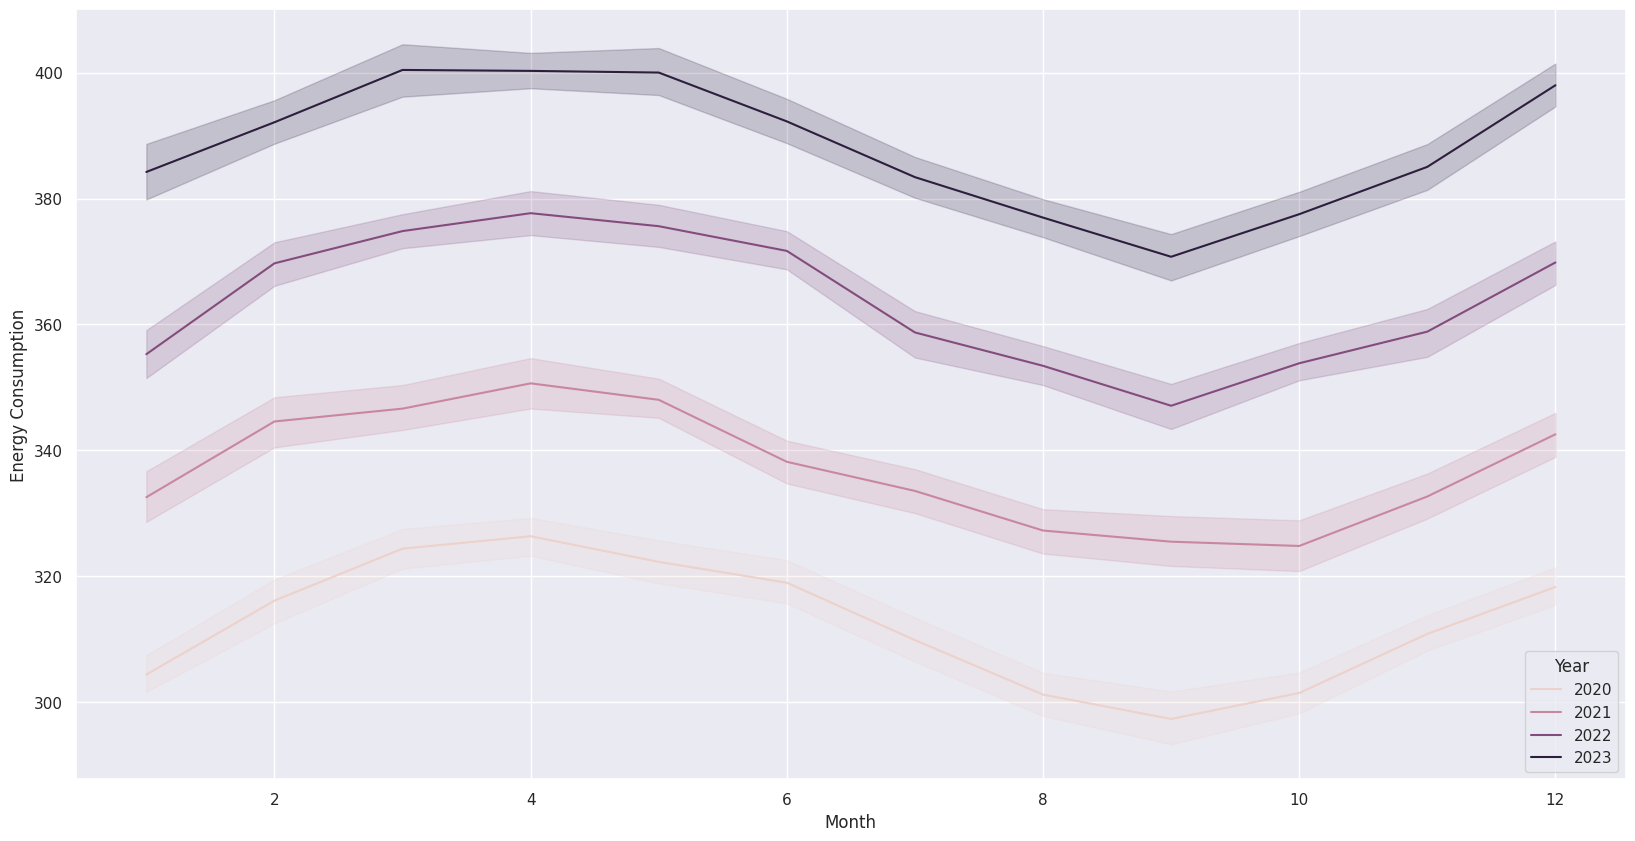

In [29]:
sns.set(rc={'figure.figsize':(20, 10)})

sns.lineplot(data, x='Month', y='Energy Consumption', hue='Year')

<Axes: xlabel='Day', ylabel='Energy Consumption'>

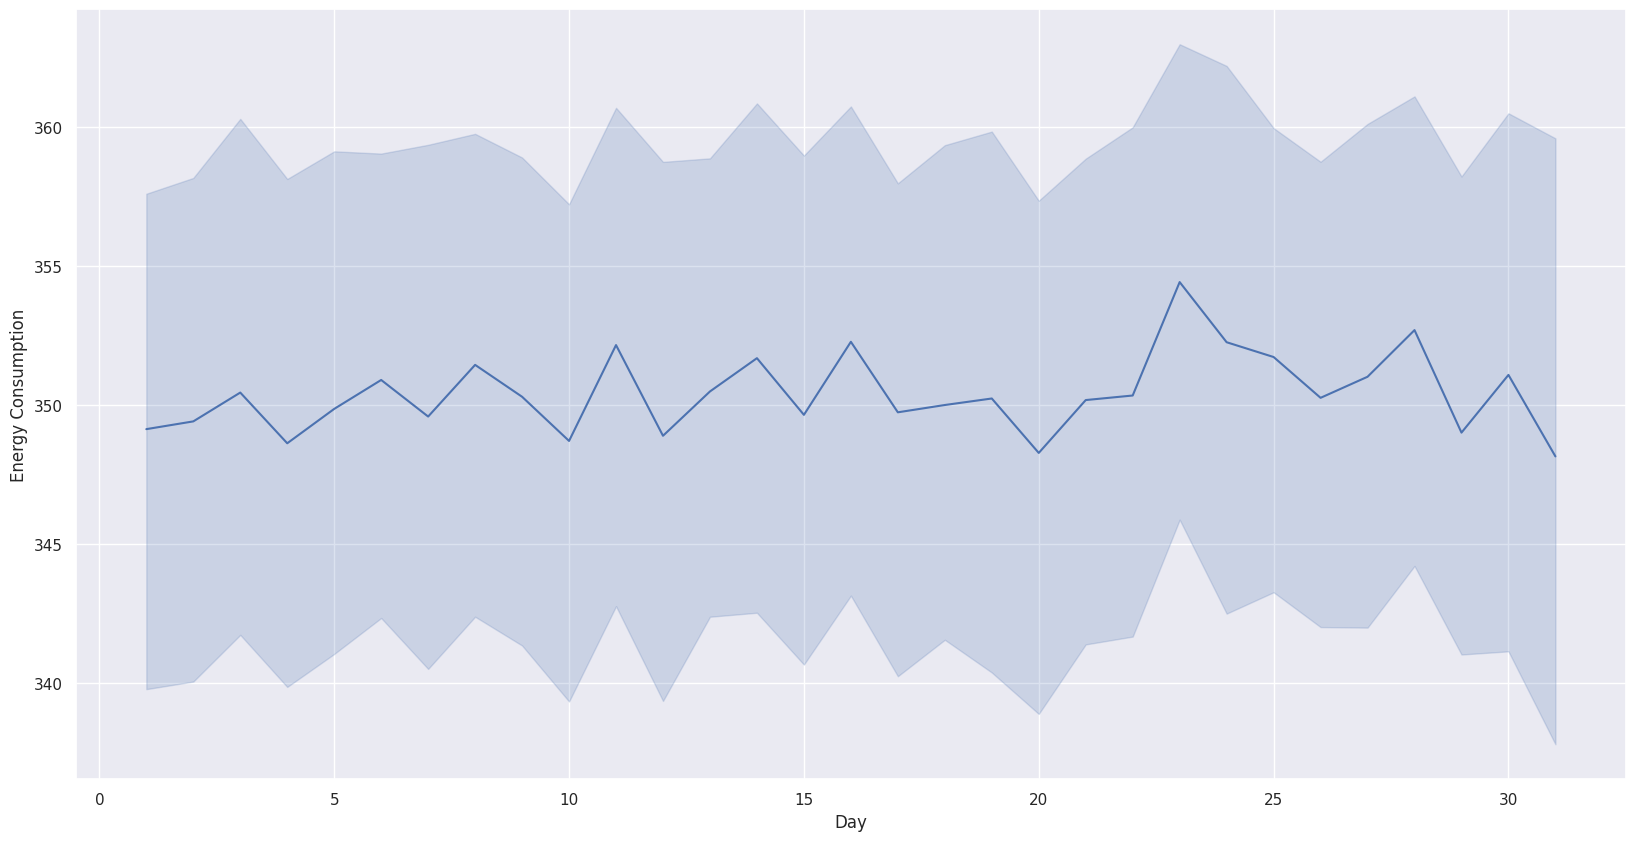

In [30]:
sns.lineplot(data, x='Day', y='Energy Consumption')

<Axes: xlabel='Year', ylabel='Energy Consumption'>

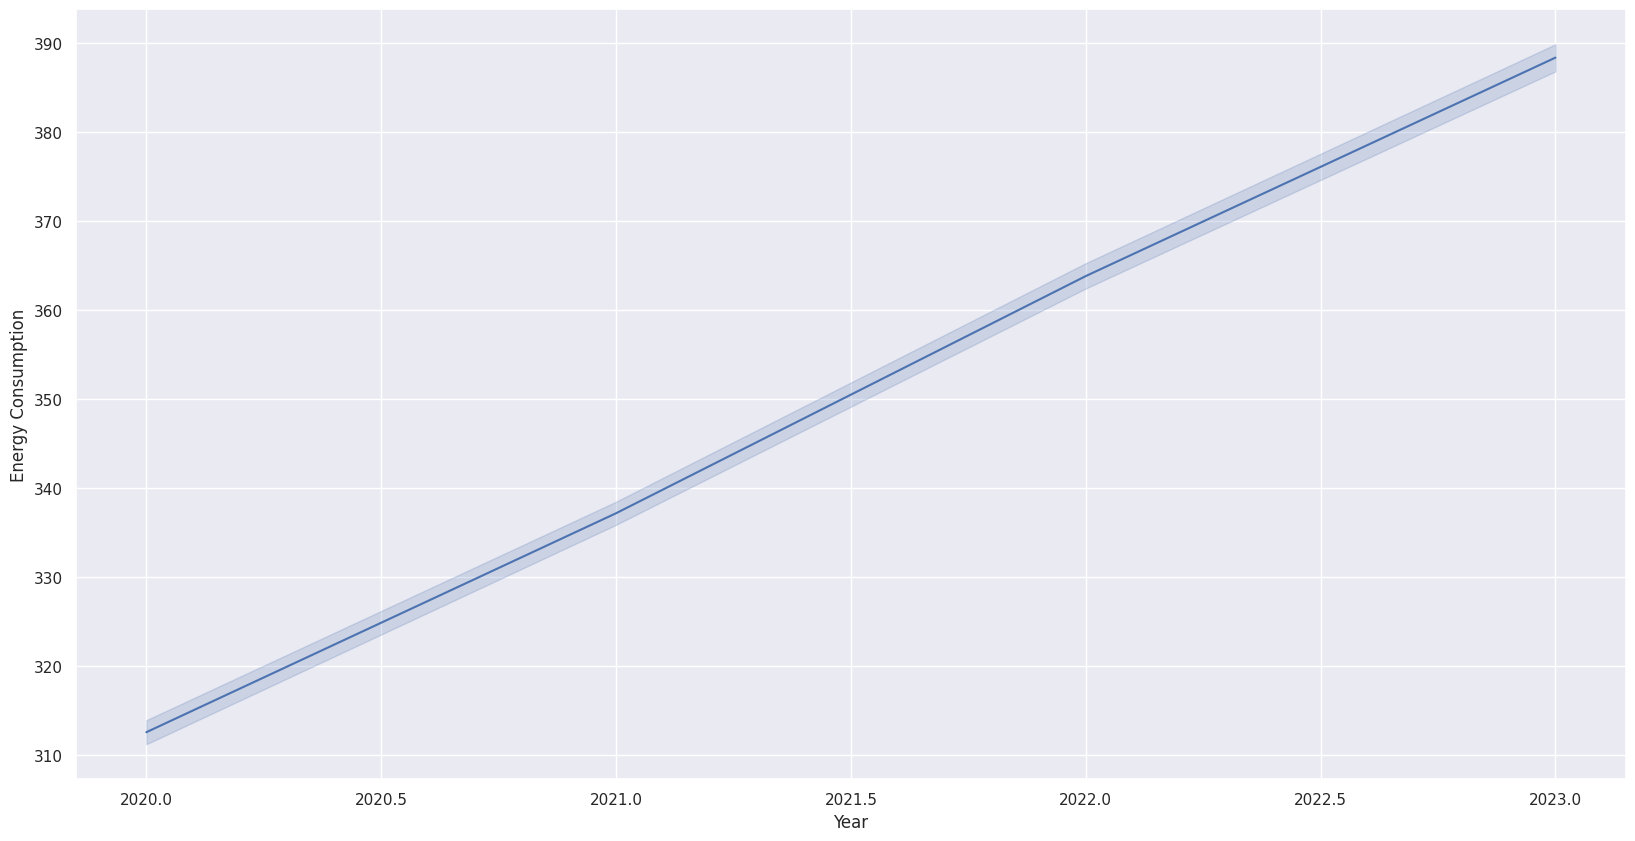

In [31]:
sns.lineplot(data, x='Year', y='Energy Consumption')

In [32]:
scaler = MinMaxScaler(feature_range=(0, 1))
data['Energy Consumption'] = scaler.fit_transform(data[['Energy Consumption']])

data

,Date,Energy Consumption,Year,Month,Day
0,2020-01-01,0.249075,2020,1,1
1,2020-01-02,0.211566,2020,1,2
2,2020-01-03,0.263826,2020,1,3
3,2020-01-04,0.321731,2020,1,4
4,2020-01-05,0.213320,2020,1,5
...,...,...,...,...,...
1455,2023-12-26,0.723452,2023,12,26
1456,2023-12-27,0.884886,2023,12,27
1457,2023-12-28,0.863977,2023,12,28
1458,2023-12-29,0.923985,2023,12,29


In [61]:
train_data = data[data['Year'] <= 2022]

train_data

,Date,Energy Consumption,Year,Month,Day
0,2020-01-01,0.249075,2020,1,1
1,2020-01-02,0.211566,2020,1,2
2,2020-01-03,0.263826,2020,1,3
3,2020-01-04,0.321731,2020,1,4
4,2020-01-05,0.213320,2020,1,5
...,...,...,...,...,...
1091,2022-12-27,0.676891,2022,12,27
1092,2022-12-28,0.727816,2022,12,28
1093,2022-12-29,0.687735,2022,12,29
1094,2022-12-30,0.733346,2022,12,30


In [62]:
test_data = data[data['Year'] > 2022]

test_data

,Date,Energy Consumption,Year,Month,Day
1096,2023-01-01,0.697244,2023,1,1
1097,2023-01-02,0.568644,2023,1,2
1098,2023-01-03,0.755380,2023,1,3
1099,2023-01-04,0.721984,2023,1,4
1100,2023-01-05,0.765746,2023,1,5
...,...,...,...,...,...
1455,2023-12-26,0.723452,2023,12,26
1456,2023-12-27,0.884886,2023,12,27
1457,2023-12-28,0.863977,2023,12,28
1458,2023-12-29,0.923985,2023,12,29


In [63]:
train = train_data[['Energy Consumption']].values
test = test_data[['Energy Consumption']].values

In [68]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+lookback]
        X.append(feature)
        y.append(target)
    
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [69]:
X_train, y_train = create_dataset(train, lookback=7)
X_test, y_test = create_dataset(test, lookback=7)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([1089, 7, 1]) torch.Size([1089, 1])
torch.Size([357, 7, 1]) torch.Size([357, 1])


In [112]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])
        return out

## 1- Number of Neurons influence on the model
### Config 1: 1 layer, 128 neurons, 100 epochs, optimizer=adam, loss='mse', droput=0.2

In [128]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


def train(X_train, y_train, X_test, y_test, input_size, hidden_size, num_layers, dropout, num_epochs = 100):
    model = LSTMModel(input_size, hidden_size, num_layers, dropout).to(device)
    loss_fn = nn.MSELoss(reduction='mean')
    optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Learning rate

    batch_size = 128  # Adjusted batch size
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    train_hist = []
    test_hist = []

    for epoch in range(num_epochs):
        total_loss = 0.0
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            predictions = model(batch_X)
            loss = loss_fn(predictions, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(train_loader)
        train_hist.append(average_loss)

        model.eval()
        with torch.no_grad():
            total_test_loss = 0.0

            for batch_X_test, batch_y_test in test_loader:
                batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
                predictions_test = model(batch_X_test)
                test_loss = loss_fn(predictions_test, batch_y_test)

                total_test_loss += test_loss.item()

            average_test_loss = total_test_loss / len(test_loader)
            test_hist.append(average_test_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

    return model, test_loader, train_hist, test_hist

cpu


In [130]:
model, test_loader, train_hist, test_hist = train(X_train, y_train, X_test, y_test, input_size = 1, hidden_size = 128, num_layers = 1, dropout = 0.2, num_epochs = 100)

Epoch [10/100] - Training Loss: 0.0474, Test Loss: 0.1862
Epoch [20/100] - Training Loss: 0.0176, Test Loss: 0.0671
Epoch [30/100] - Training Loss: 0.0147, Test Loss: 0.0518
Epoch [40/100] - Training Loss: 0.0111, Test Loss: 0.0320
Epoch [50/100] - Training Loss: 0.0071, Test Loss: 0.0110
Epoch [60/100] - Training Loss: 0.0047, Test Loss: 0.0054
Epoch [70/100] - Training Loss: 0.0046, Test Loss: 0.0069
Epoch [80/100] - Training Loss: 0.0046, Test Loss: 0.0073
Epoch [90/100] - Training Loss: 0.0045, Test Loss: 0.0071
Epoch [100/100] - Training Loss: 0.0046, Test Loss: 0.0070


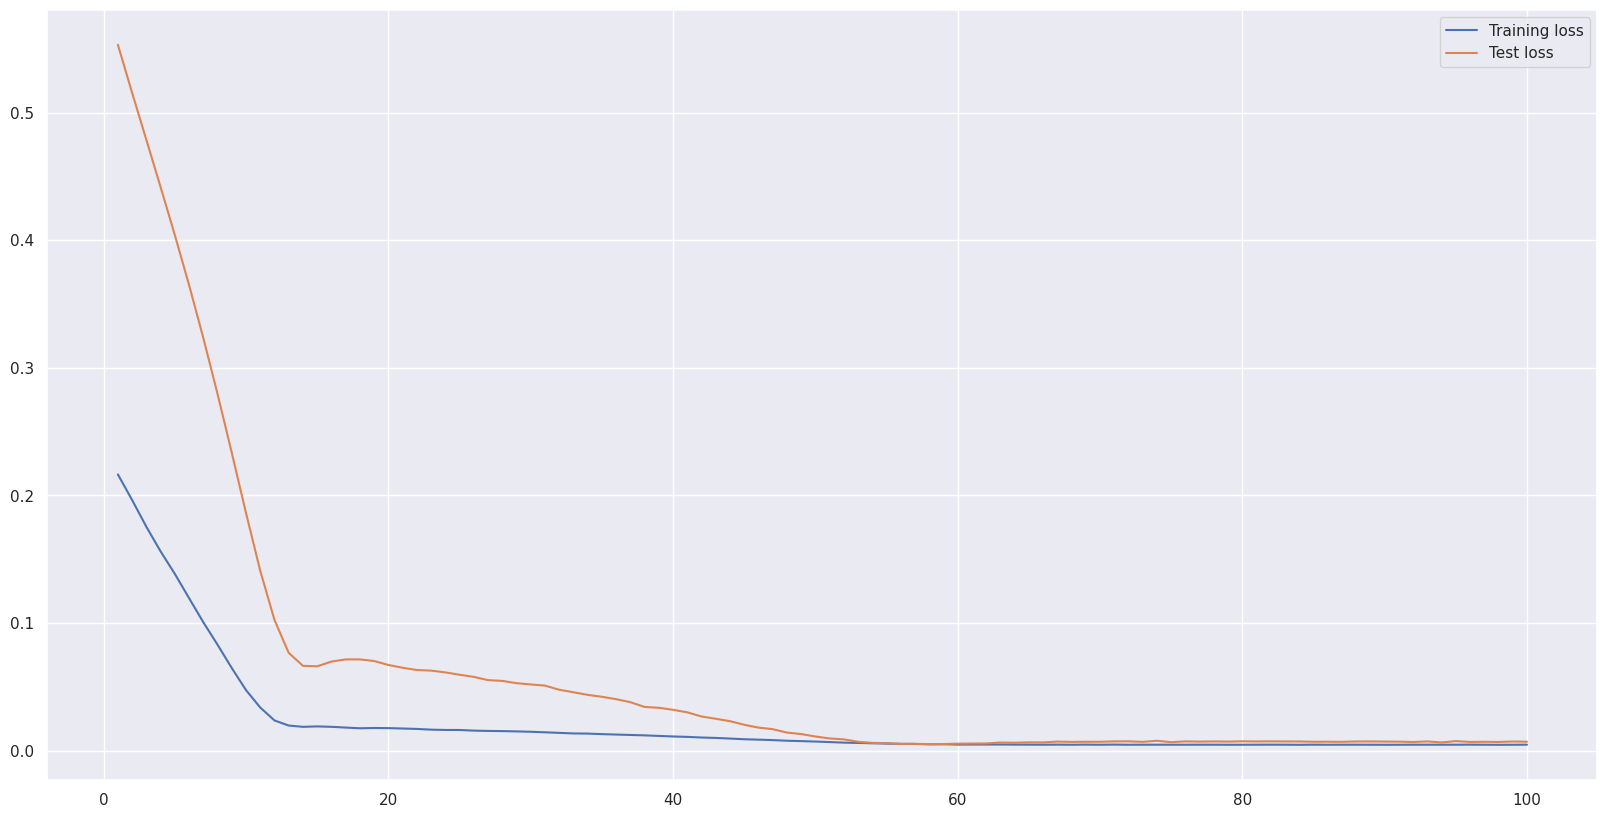

In [131]:
x = np.linspace(1, 100, 100)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

In [132]:
def evaluate(model, test_loader):
    forecasted_values = []
    with torch.no_grad():
        for batch_X_test, _ in test_loader:
            batch_X_test = batch_X_test.to(device)
            predictions_test = model(batch_X_test)
            forecasted_values.extend(predictions_test.cpu().numpy())

    return np.array(forecasted_values).flatten()

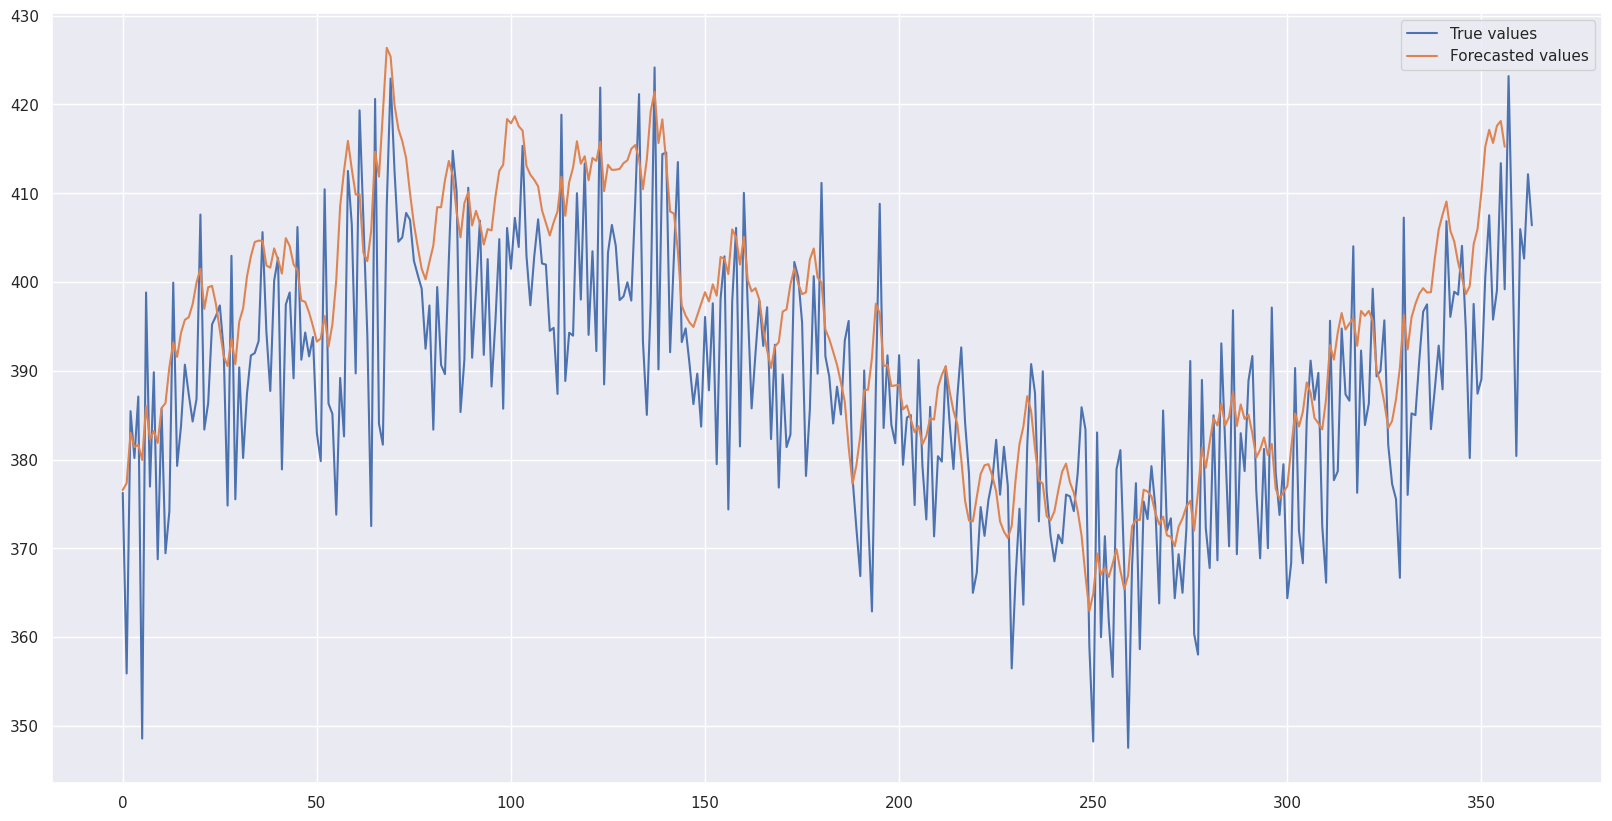

In [133]:
forecasted_values = evaluate(model, test_loader)

plt.plot(scaler.inverse_transform(test_data['Energy Consumption'].values.reshape(-1, 1)).flatten(), label='True values')
plt.plot(scaler.inverse_transform(forecasted_values.reshape(-1, 1)).flatten(), label='Forecasted values')
plt.legend()
plt.show()

### Config 1: 1 layer, 256 neurons, 100 epochs, optimizer=adam, loss='mse', droput=0.2

In [134]:
model, test_loader, train_hist, test_hist = train(X_train, y_train, X_test, y_test, input_size = 1, hidden_size = 256, num_layers = 1, dropout = 0.2, num_epochs = 100)

/home/lonewolf/projects/dl-tl-labs/.venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch [10/100] - Training Loss: 0.0201, Test Loss: 0.0591
Epoch [20/100] - Training Loss: 0.0141, Test Loss: 0.0471
Epoch [30/100] - Training Loss: 0.0087, Test Loss: 0.0188
Epoch [40/100] - Training Loss: 0.0049, Test Loss: 0.0055
Epoch [50/100] - Training Loss: 0.0046, Test Loss: 0.0069
Epoch [60/100] - Training Loss: 0.0046, Test Loss: 0.0068
Epoch [70/100] - Training Loss: 0.0047, Test Loss: 0.0065
Epoch [80/100] - Training Loss: 0.0046, Test Loss: 0.0061
Epoch [90/100] - Training Loss: 0.0046, Test Loss: 0.0064
Epoch [100/100] - Training Loss: 0.0045, Test Loss: 0.0068


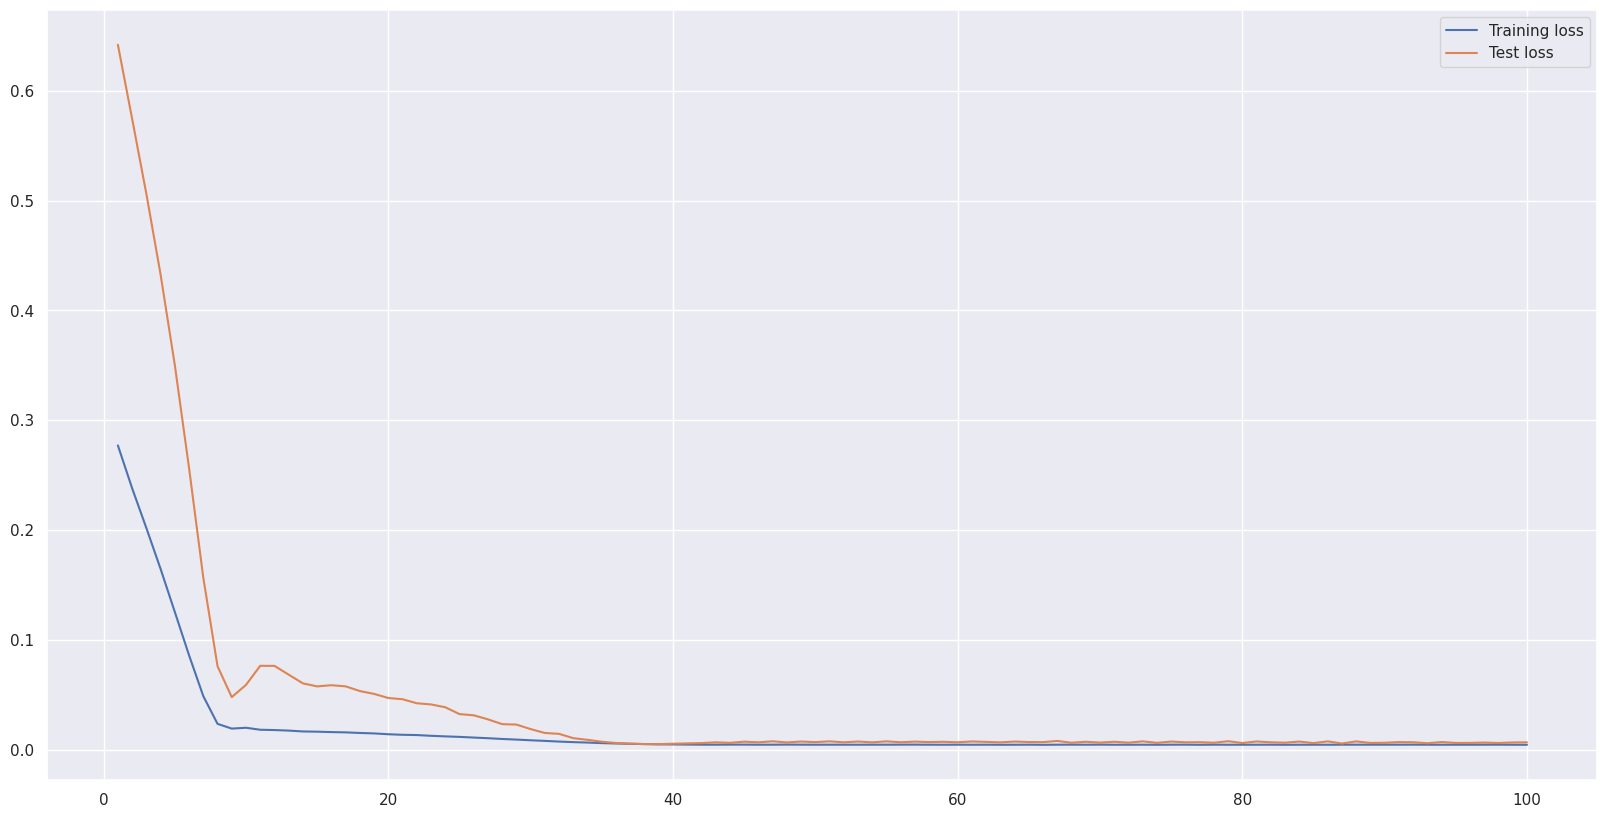

In [135]:
x = np.linspace(1, 100, 100)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

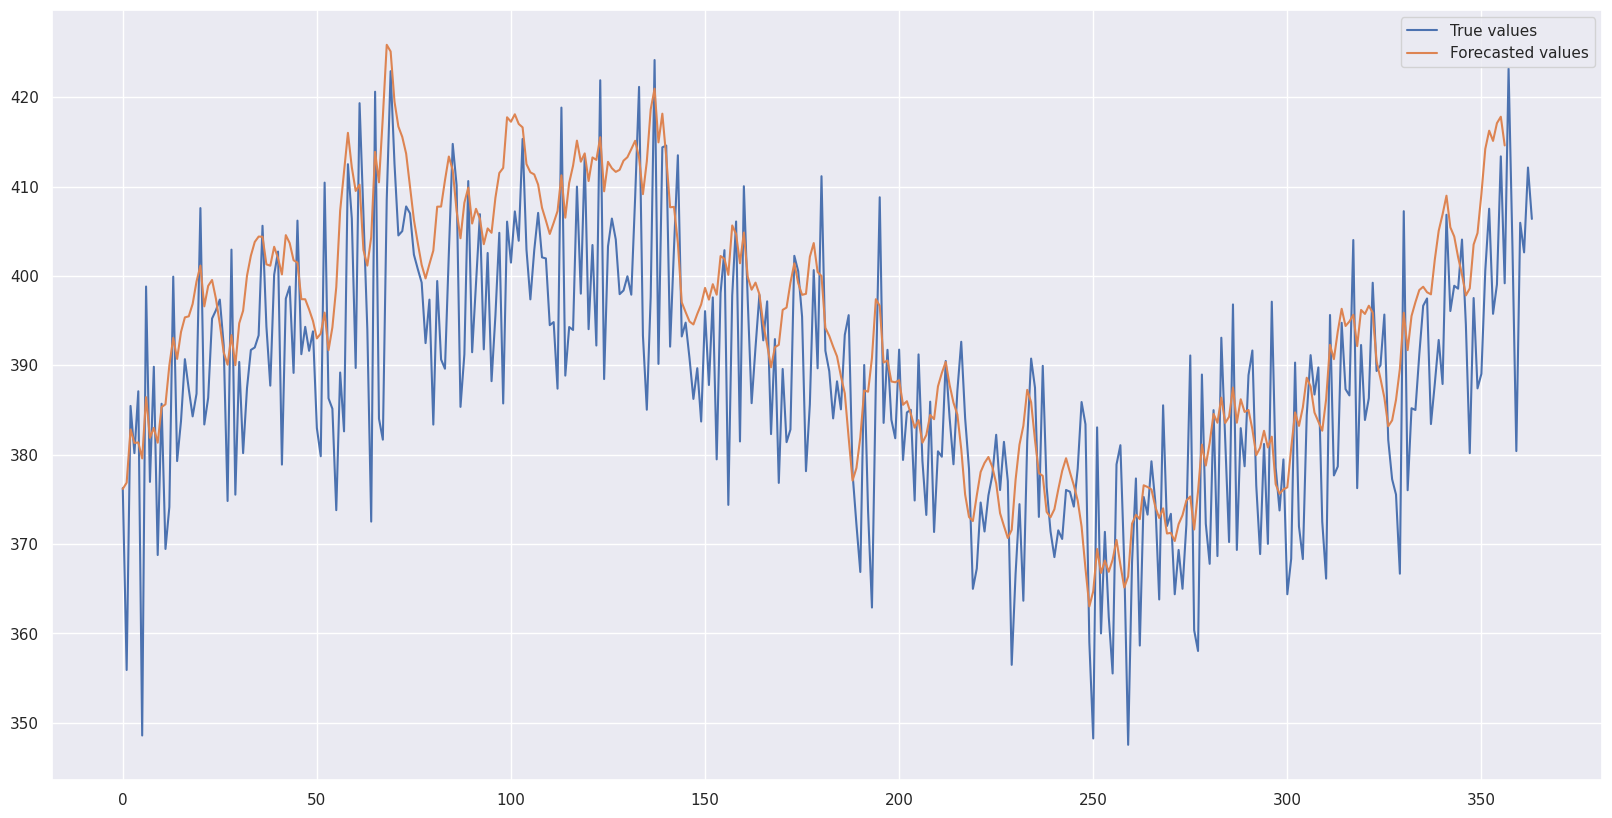

In [136]:
forecasted_values = evaluate(model, test_loader)

plt.plot(scaler.inverse_transform(test_data['Energy Consumption'].values.reshape(-1, 1)).flatten(), label='True values')
plt.plot(scaler.inverse_transform(forecasted_values.reshape(-1, 1)).flatten(), label='Forecasted values')
plt.legend()
plt.show()

### Config 1: 1 layer, 512 neurons, 100 epochs, optimizer=adam, loss='mse', droput=0.2

In [137]:
model, test_loader, train_hist, test_hist = train(X_train, y_train, X_test, y_test, input_size = 1, hidden_size = 512, num_layers = 1, dropout = 0.2, num_epochs = 100)

/home/lonewolf/projects/dl-tl-labs/.venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch [10/100] - Training Loss: 0.0167, Test Loss: 0.0573
Epoch [20/100] - Training Loss: 0.0074, Test Loss: 0.0110
Epoch [30/100] - Training Loss: 0.0046, Test Loss: 0.0062
Epoch [40/100] - Training Loss: 0.0046, Test Loss: 0.0056
Epoch [50/100] - Training Loss: 0.0046, Test Loss: 0.0061
Epoch [60/100] - Training Loss: 0.0046, Test Loss: 0.0063
Epoch [70/100] - Training Loss: 0.0046, Test Loss: 0.0061
Epoch [80/100] - Training Loss: 0.0046, Test Loss: 0.0057
Epoch [90/100] - Training Loss: 0.0046, Test Loss: 0.0052
Epoch [100/100] - Training Loss: 0.0045, Test Loss: 0.0055


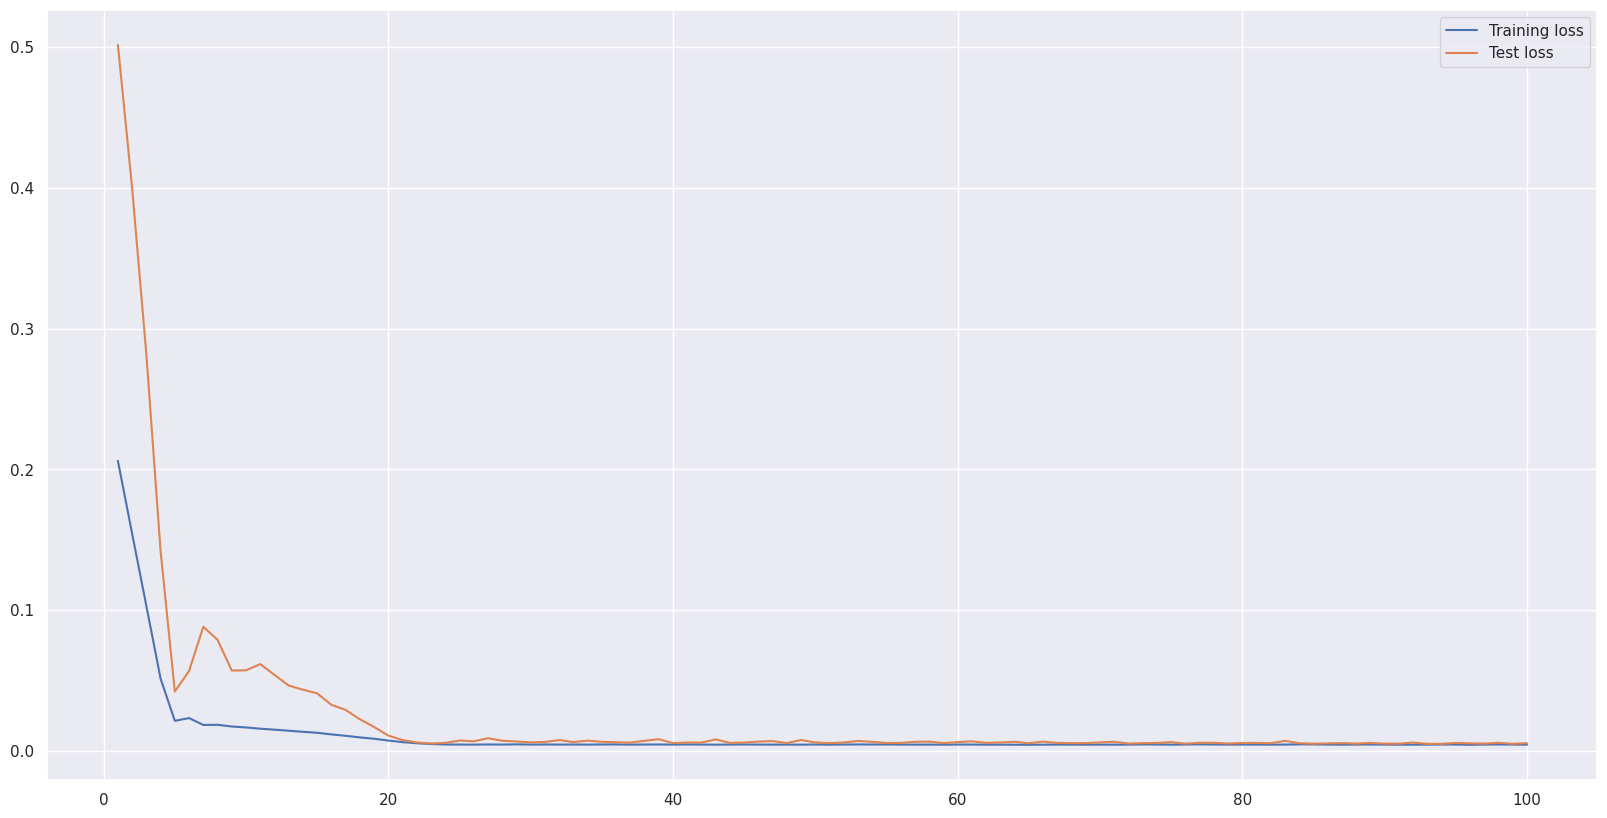

In [138]:
x = np.linspace(1, 100, 100)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

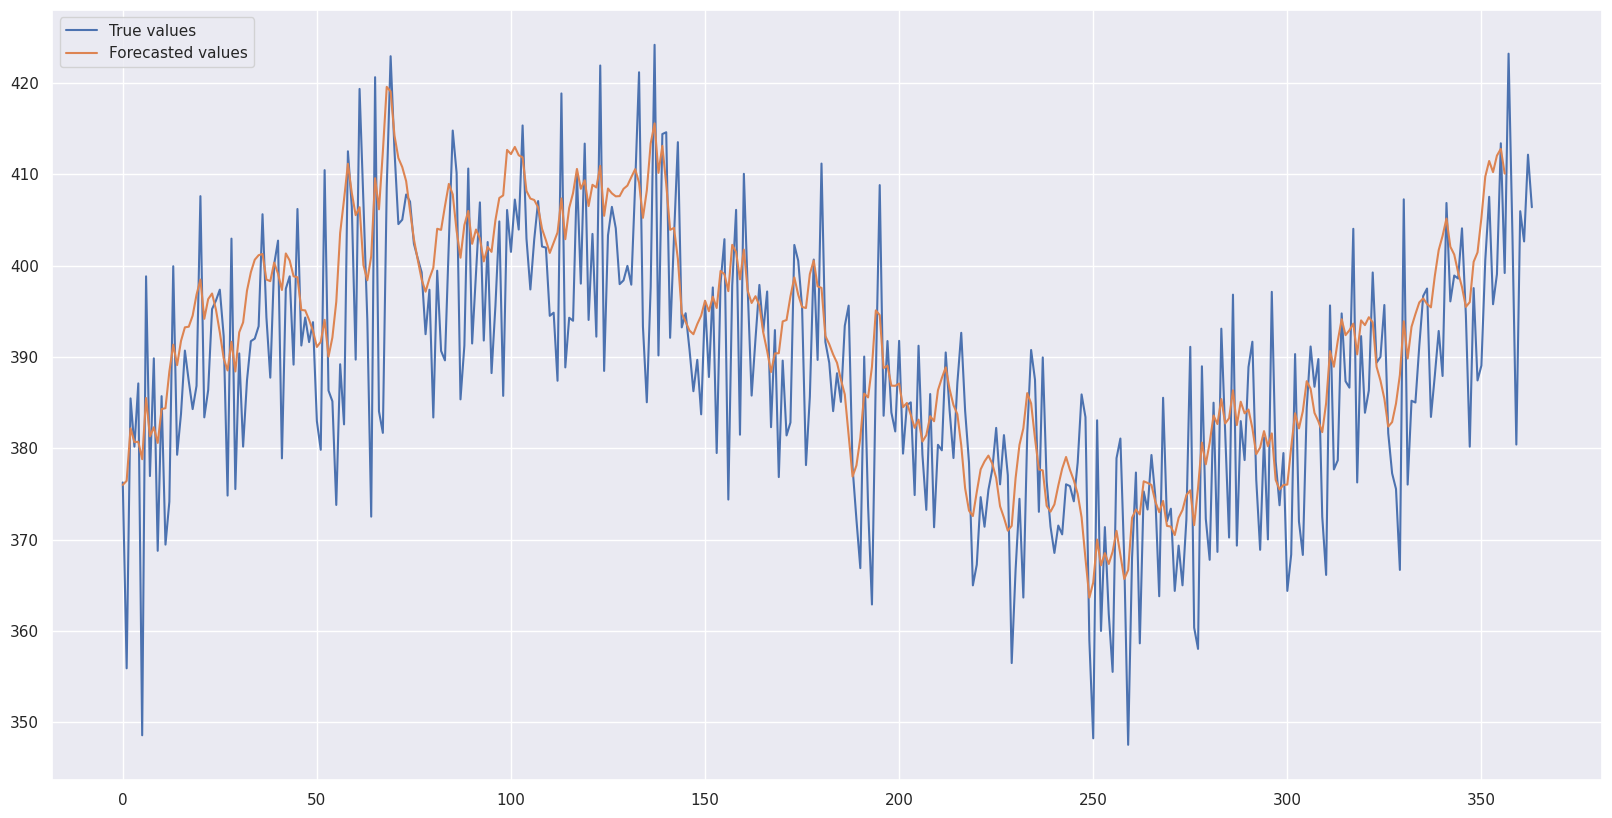

In [139]:
forecasted_values = evaluate(model, test_loader)

plt.plot(scaler.inverse_transform(test_data['Energy Consumption'].values.reshape(-1, 1)).flatten(), label='True values')
plt.plot(scaler.inverse_transform(forecasted_values.reshape(-1, 1)).flatten(), label='Forecasted values')
plt.legend()
plt.show()

In [140]:
model, test_loader, train_hist, test_hist = train(X_train, y_train, X_test, y_test, input_size = 1, hidden_size = 512, num_layers = 2, dropout = 0.2, num_epochs = 100)

Epoch [10/100] - Training Loss: 0.0152, Test Loss: 0.0473
Epoch [20/100] - Training Loss: 0.0047, Test Loss: 0.0061
Epoch [30/100] - Training Loss: 0.0046, Test Loss: 0.0060
Epoch [40/100] - Training Loss: 0.0047, Test Loss: 0.0054
Epoch [50/100] - Training Loss: 0.0045, Test Loss: 0.0060
Epoch [60/100] - Training Loss: 0.0045, Test Loss: 0.0056
Epoch [70/100] - Training Loss: 0.0046, Test Loss: 0.0062
Epoch [80/100] - Training Loss: 0.0045, Test Loss: 0.0050
Epoch [90/100] - Training Loss: 0.0045, Test Loss: 0.0048
Epoch [100/100] - Training Loss: 0.0046, Test Loss: 0.0048


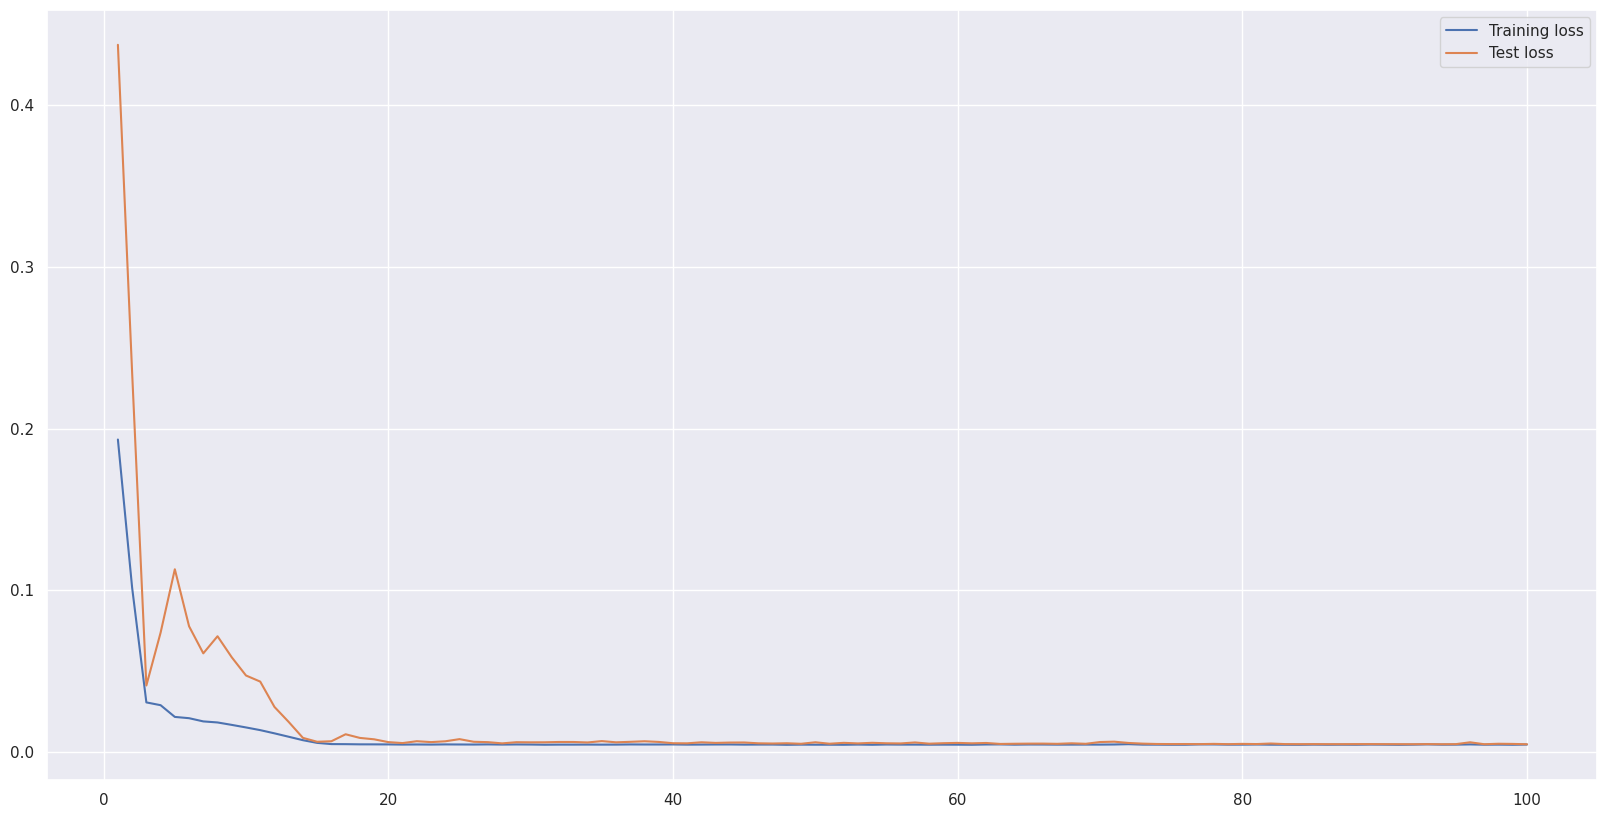

In [141]:
x = np.linspace(1, 100, 100)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

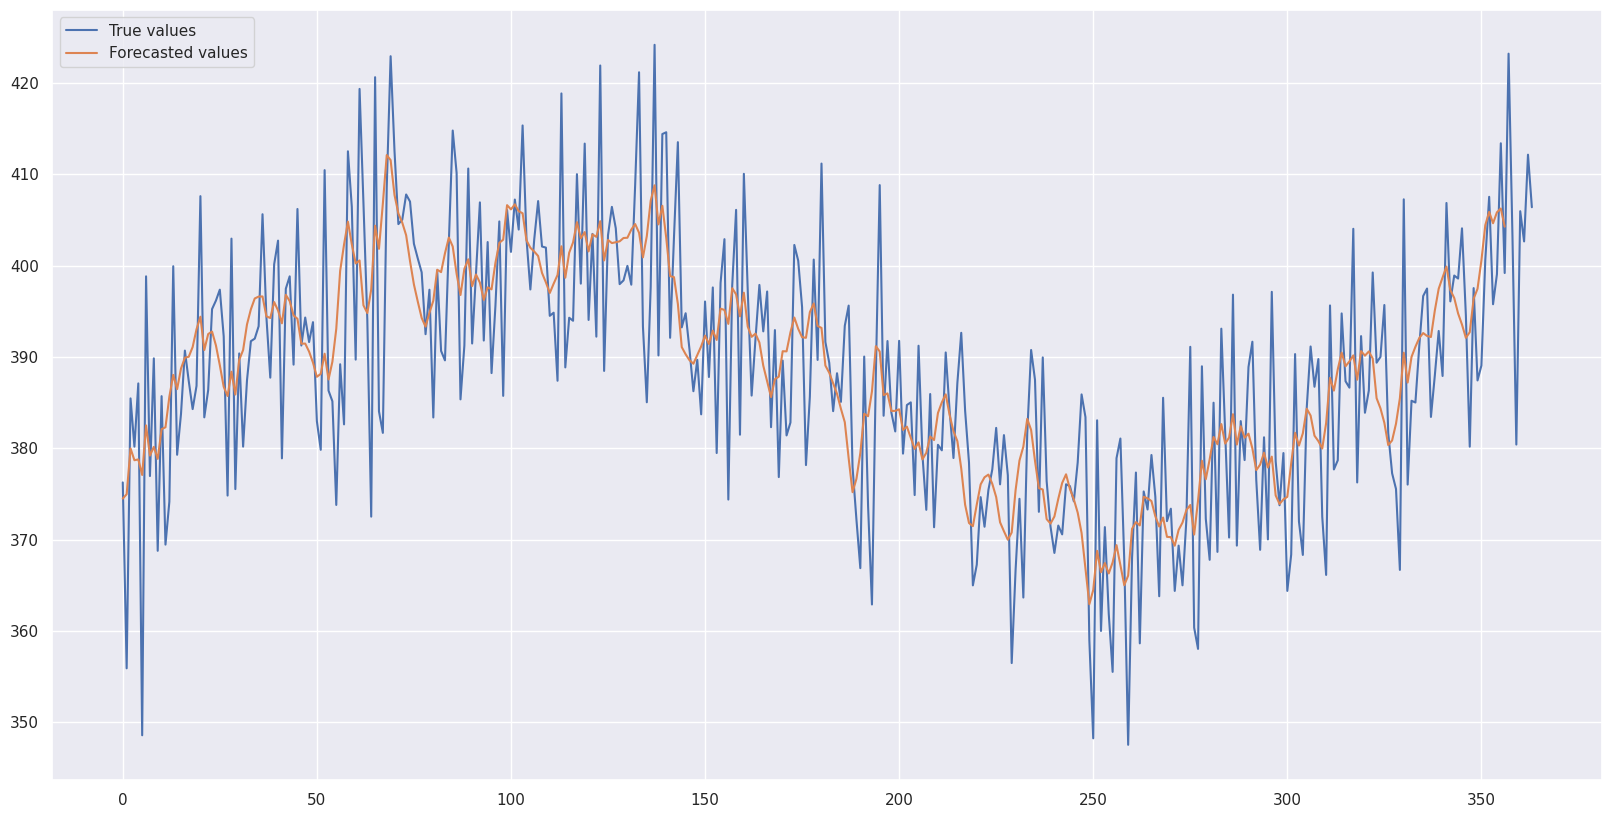

In [142]:
forecasted_values = evaluate(model, test_loader)

plt.plot(scaler.inverse_transform(test_data['Energy Consumption'].values.reshape(-1, 1)).flatten(), label='True values')
plt.plot(scaler.inverse_transform(forecasted_values.reshape(-1, 1)).flatten(), label='Forecasted values')
plt.legend()
plt.show()

In [143]:
model, test_loader, train_hist, test_hist = train(X_train, y_train, X_test, y_test, input_size = 1, hidden_size = 512, num_layers = 3, dropout = 0.2, num_epochs = 100)

Epoch [10/100] - Training Loss: 0.0183, Test Loss: 0.0667
Epoch [20/100] - Training Loss: 0.0048, Test Loss: 0.0071
Epoch [30/100] - Training Loss: 0.0047, Test Loss: 0.0059
Epoch [40/100] - Training Loss: 0.0046, Test Loss: 0.0053
Epoch [50/100] - Training Loss: 0.0047, Test Loss: 0.0052
Epoch [60/100] - Training Loss: 0.0045, Test Loss: 0.0050
Epoch [70/100] - Training Loss: 0.0046, Test Loss: 0.0049
Epoch [80/100] - Training Loss: 0.0049, Test Loss: 0.0051
Epoch [90/100] - Training Loss: 0.0048, Test Loss: 0.0050
Epoch [100/100] - Training Loss: 0.0045, Test Loss: 0.0049


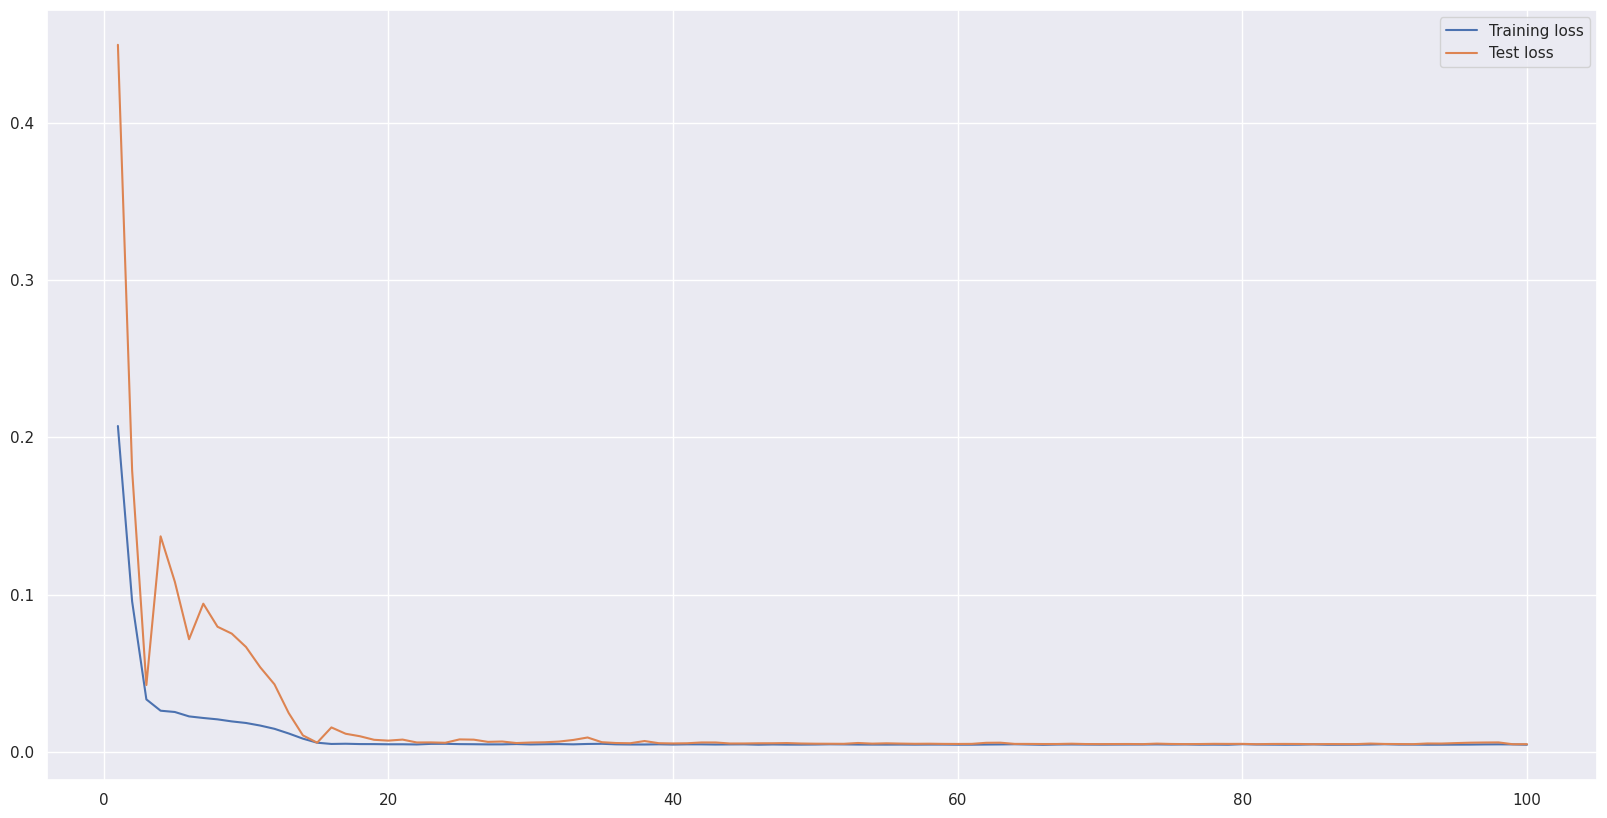

In [144]:
x = np.linspace(1, 100, 100)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

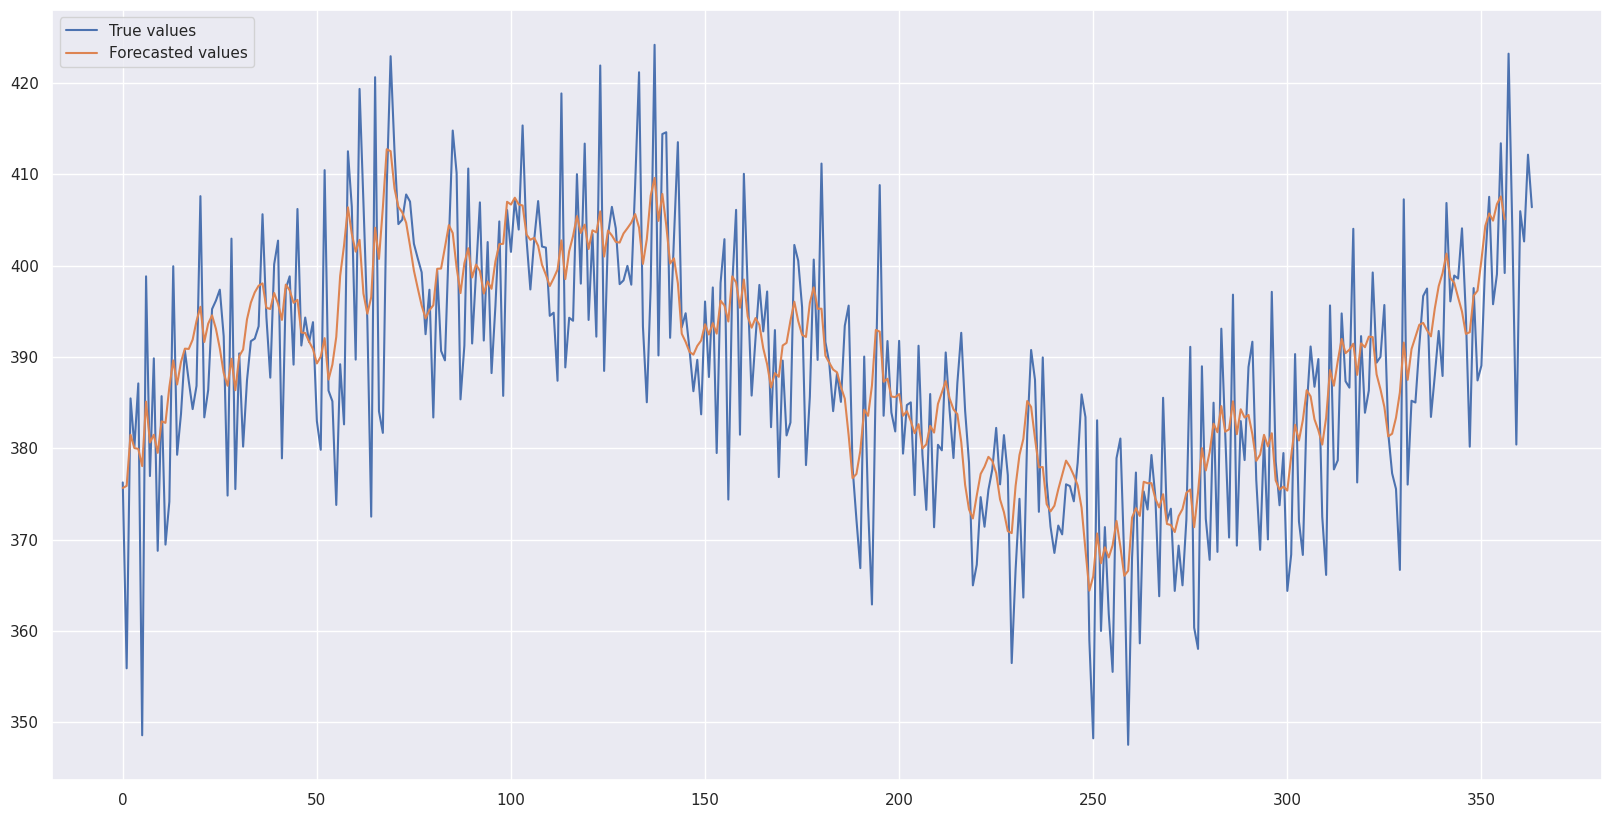

In [145]:
forecasted_values = evaluate(model, test_loader)

plt.plot(scaler.inverse_transform(test_data['Energy Consumption'].values.reshape(-1, 1)).flatten(), label='True values')
plt.plot(scaler.inverse_transform(forecasted_values.reshape(-1, 1)).flatten(), label='Forecasted values')
plt.legend()
plt.show()

In [146]:
model, test_loader, train_hist, test_hist = train(X_train, y_train, X_test, y_test, input_size = 1, hidden_size = 512, num_layers = 4, dropout = 0.2, num_epochs = 100)

Epoch [10/100] - Training Loss: 0.0203, Test Loss: 0.0744
Epoch [20/100] - Training Loss: 0.0050, Test Loss: 0.0070
Epoch [30/100] - Training Loss: 0.0049, Test Loss: 0.0055
Epoch [40/100] - Training Loss: 0.0047, Test Loss: 0.0050
Epoch [50/100] - Training Loss: 0.0047, Test Loss: 0.0050
Epoch [60/100] - Training Loss: 0.0049, Test Loss: 0.0057
Epoch [70/100] - Training Loss: 0.0049, Test Loss: 0.0069
Epoch [80/100] - Training Loss: 0.0048, Test Loss: 0.0049
Epoch [90/100] - Training Loss: 0.0048, Test Loss: 0.0053
Epoch [100/100] - Training Loss: 0.0048, Test Loss: 0.0049


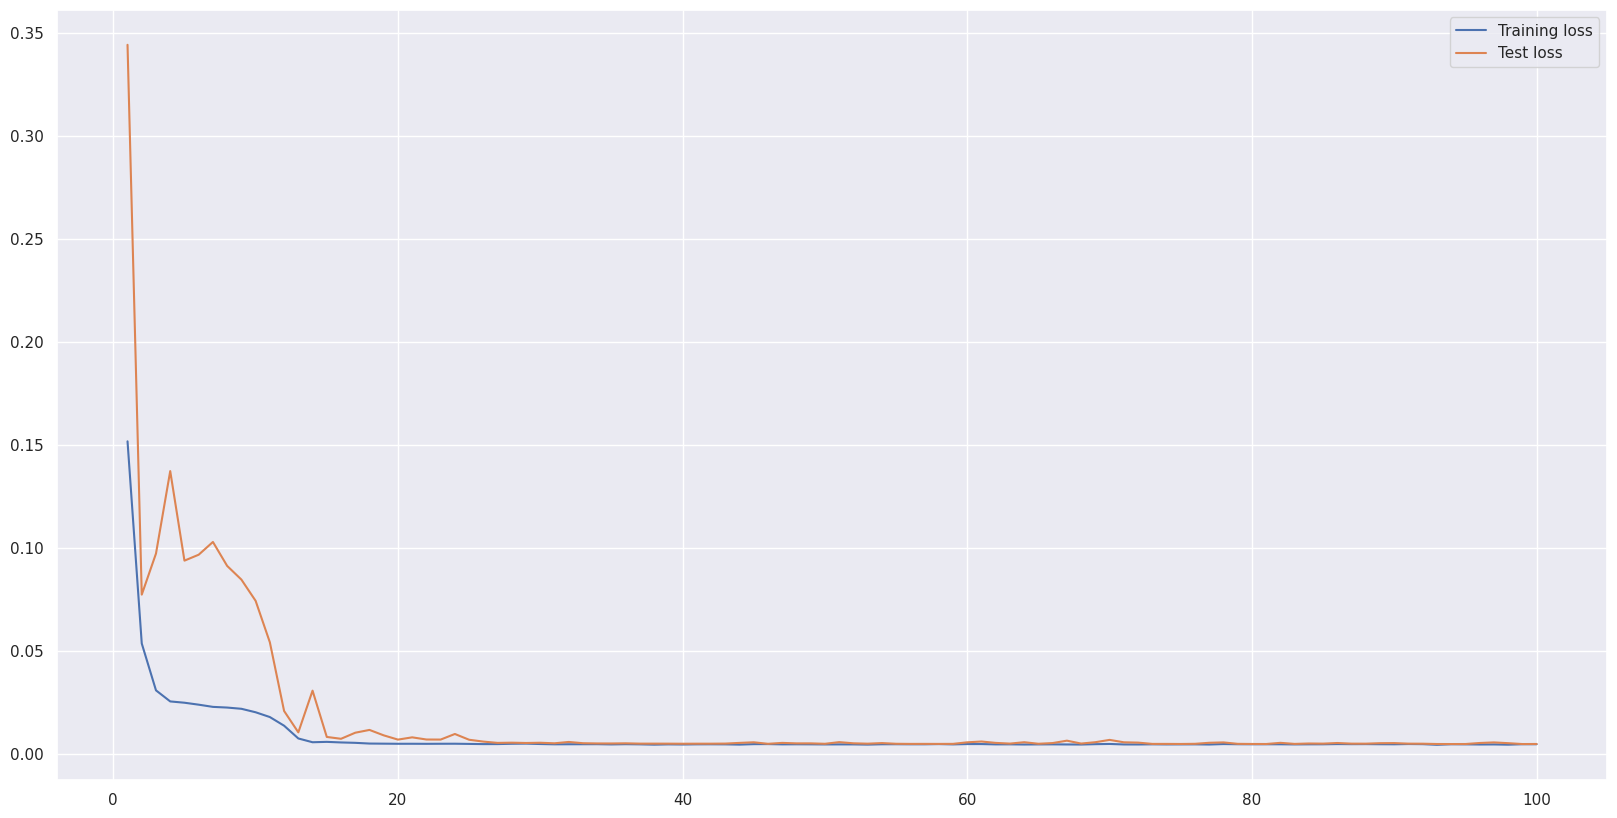

In [147]:
x = np.linspace(1, 100, 100)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

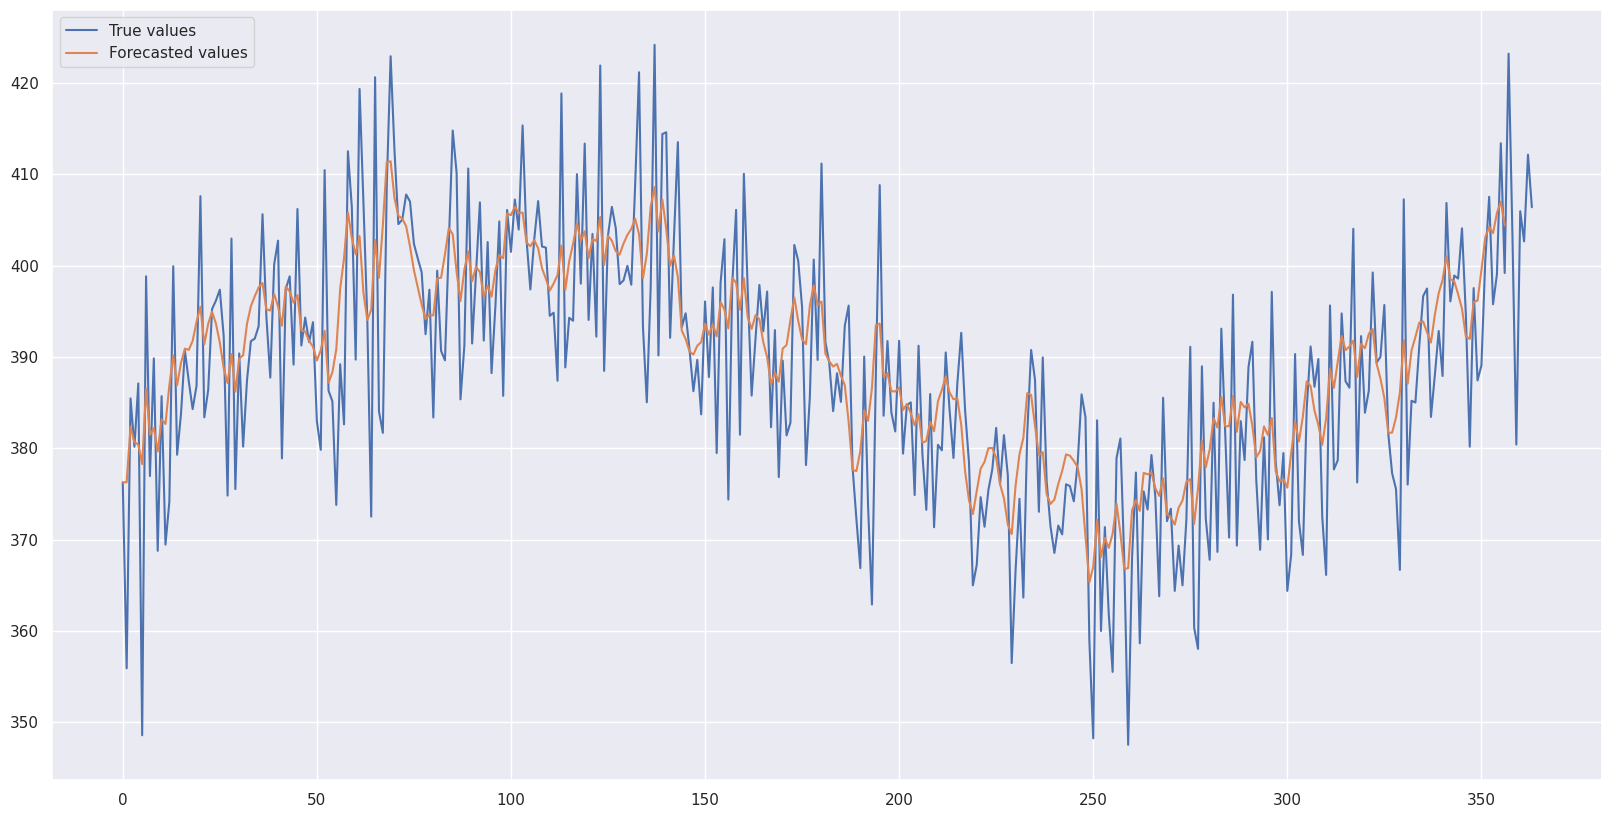

In [148]:
forecasted_values = evaluate(model, test_loader)

plt.plot(scaler.inverse_transform(test_data['Energy Consumption'].values.reshape(-1, 1)).flatten(), label='True values')
plt.plot(scaler.inverse_transform(forecasted_values.reshape(-1, 1)).flatten(), label='Forecasted values')
plt.legend()
plt.show()